In [1]:
import requests
from bs4 import BeautifulSoup
import lxml

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import numpy as np

%matplotlib inline



In [2]:
# Call for TOP 1000 papers 
QUERY = 'covid-19 OR corona virus AND (HAS_FT:Y) AND (HAS_FT:Y) AND (OPEN_ACCESS:Y)'
URL = 'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query='+QUERY+'&resultType=lite&cursorMark=*&pageSize=1000&format=json'
print(URL)

# call the URL request
r = requests.get(URL)
r_json = r.json()


'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=covid-19 OR corona virus AND (HAS_FT:Y) AND (HAS_FT:Y) AND (OPEN_ACCESS:Y)&resultType=lite&cursorMark=*&pageSize=1000&format=json'

In [4]:
# get all the open source and free to use and read papers from Europe PMC

open_acces_sentences= []

for each_pmc_id in tqdm(r_json['resultList']['result']):
    Full_TEXT_XML = 'https://www.ebi.ac.uk/europepmc/webservices/rest/'+each_pmc_id['pmcid']+'/fullTextXML'
    r = requests.get(Full_TEXT_XML)
    soup = BeautifulSoup(r.text, 'lxml')
    
    for each_p_tag in soup.findAll('p'):
        open_acces_sentences.append(each_p_tag.text)

    

100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]


In [5]:
# get all the sentences that are grater than 25 in lengths
sentences = []
for each_par in tqdm(open_acces_sentences):
    for each_sentence in each_par.split('.'):
        if len(each_sentence)>25:
            sentences.append(each_sentence.strip())

100%|██████████| 50964/50964 [00:00<00:00, 203817.51it/s]


In [6]:
# import spaCY and load gene disease ner models
import spacy
from spacy import util

## Test best model performance on test set
best_model_path = '/nfs/gns/literature/Santosh_Tirunagari/GitHub/spacy_models/pretrain_exp/best/'

print("Loading from", best_model_path)
ml_annotator = util.load_model_from_path(best_model_path)

# load this model for dependency
nlp_en = spacy.load('en')

Loading from /nfs/gns/literature/Santosh_Tirunagari/GitHub/spacy_models/pretrain_exp/best/


In [9]:
# get gene and disease pairs

def get_gene_disease_pairs(sent):
    
    sent = sent.lower()
    
    GP =''
    DS = ''
    doc = ml_annotator(sent)
    
    for ent in doc.ents:
        if ent.label_ == 'GP':
            GP = ent.text
        elif ent.label_ == 'DS':
            DS = ent.text
    # give more importance to covid-19 in the sentence. My model doesnt seem to recognise covid-19 yet as a disease
    if 'covid-19' in sent:
        DS = 'covid-19'
    
    return [GP.strip(), DS.strip()]        

In [3]:
get_gene_disease_pairs("The infection routes and pathogenesis of 2019-nCov are not fully understood by far, and the study of 2019-nCoV host cell receptor ACE2 could be valuable for the prevention and treatment of the COVID-19")

NameError: name 'get_gene_disease_pairs' is not defined

In [11]:
entity_pairs = []

for i in tqdm(sentences):
    entity_pairs.append(get_gene_disease_pairs(i))

100%|██████████| 237467/237467 [13:55<00:00, 284.13it/s]


In [2]:
# extract gene
source = [i[0] for i in entity_pairs]

# extract disease
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'gene':source, 'disease':target})

NameError: name 'entity_pairs' is not defined

In [13]:
# remove empty rows

kg_df['gene'].replace('', np.nan, inplace=True)
kg_df['disease'].replace('', np.nan, inplace=True)
kg_df.dropna(subset=['gene','disease'], inplace=True)



In [33]:
# get weights that are more than 2

new_df = kg_df.groupby(['gene','disease'])["gene"].count().reset_index(name="weight")
f_df = new_df[new_df['weight']>2]
len(f_df)

349

# Knowledge Graphs

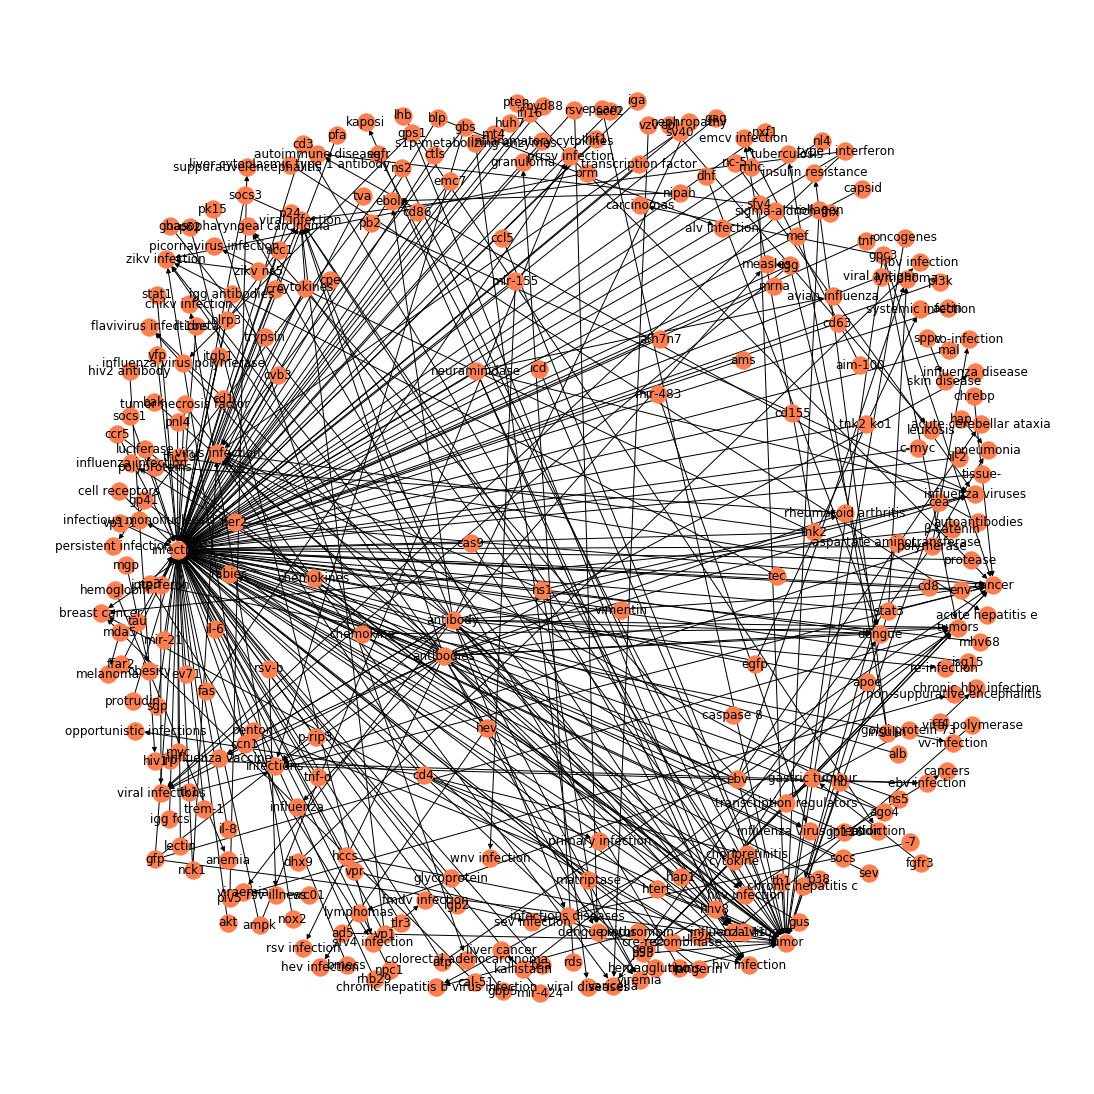

In [39]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(f_df, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,15))

# pos = nx.spring_layout(G)
pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

nx.draw(G, 
        with_labels=True, 
        node_color='coral', 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()


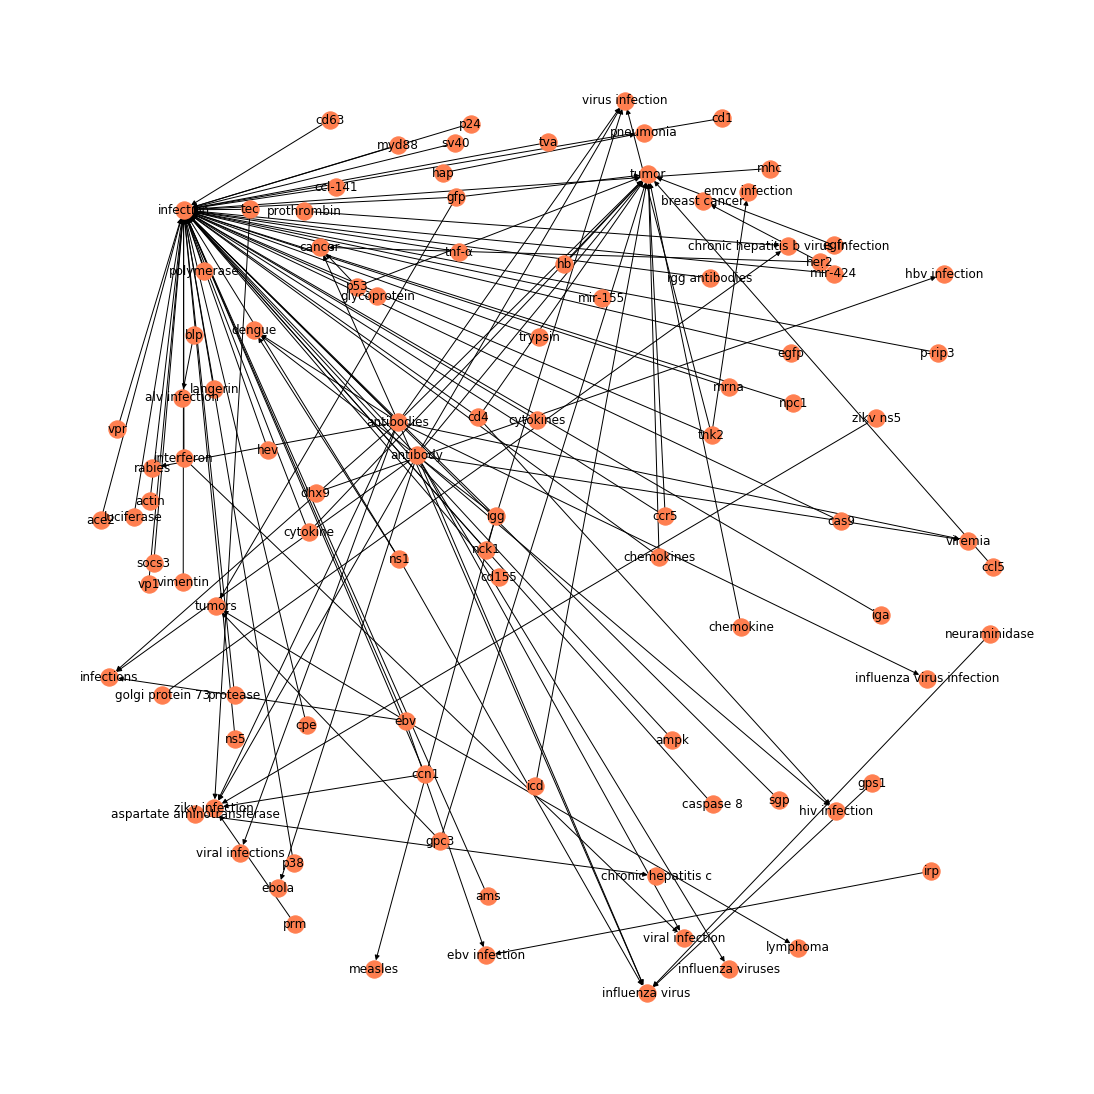

In [35]:
# Strength 5 ( 5 times occurance)
f_df_5 = new_df[new_df['weight']>5]

G=nx.from_pandas_edgelist(f_df_5, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,15))

# pos = nx.spring_layout(G)
pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

nx.draw(G, 
        with_labels=True, 
        node_color='coral', 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()

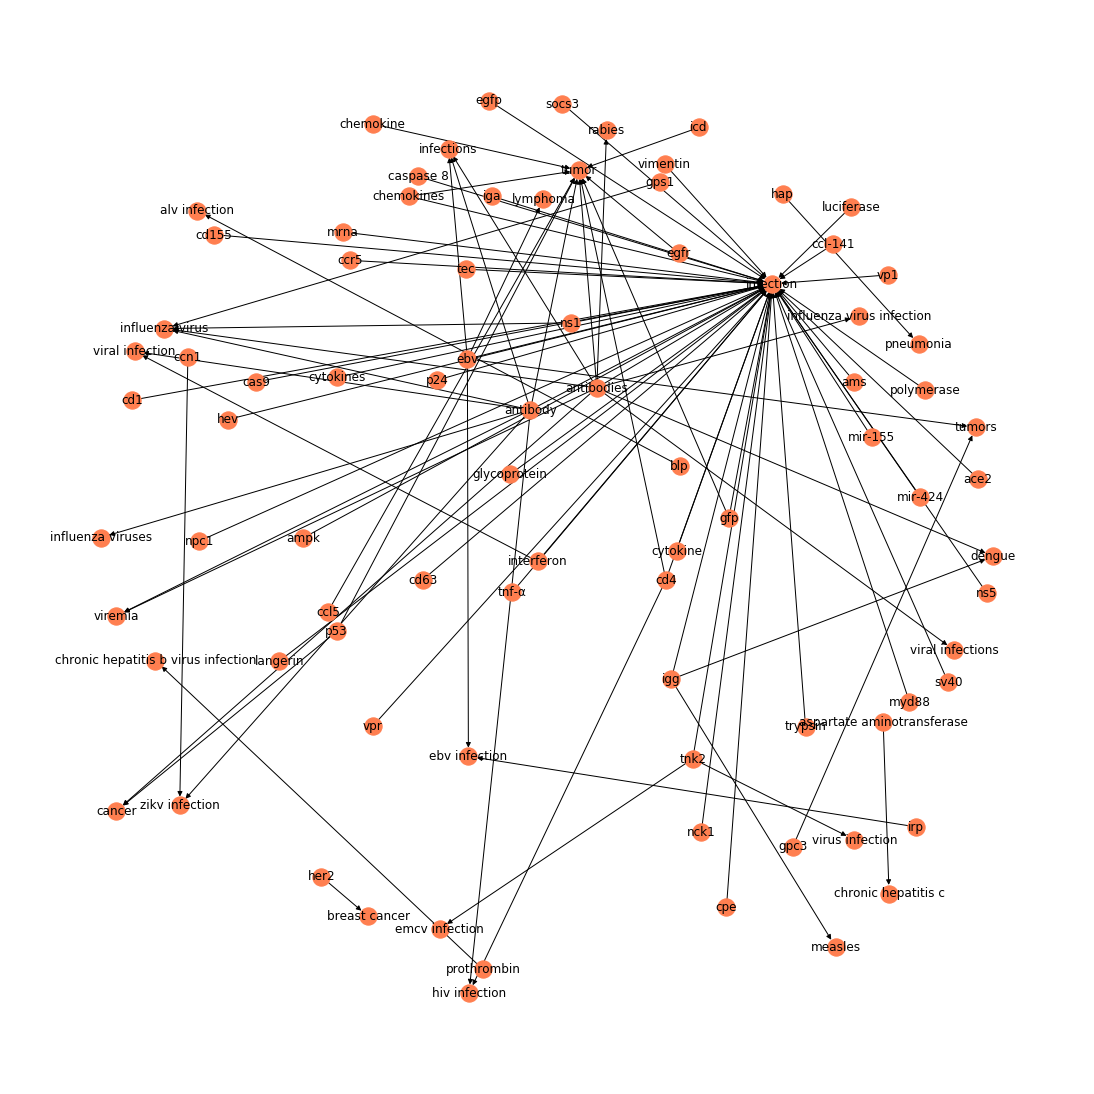

In [36]:
# Strength 6 ( more than 6 times occurance)

f_df_5 = new_df[new_df['weight']>6]

G=nx.from_pandas_edgelist(f_df_5, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,15))

# pos = nx.spring_layout(G)
pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

nx.draw(G, 
        with_labels=True, 
        node_color='coral', 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()

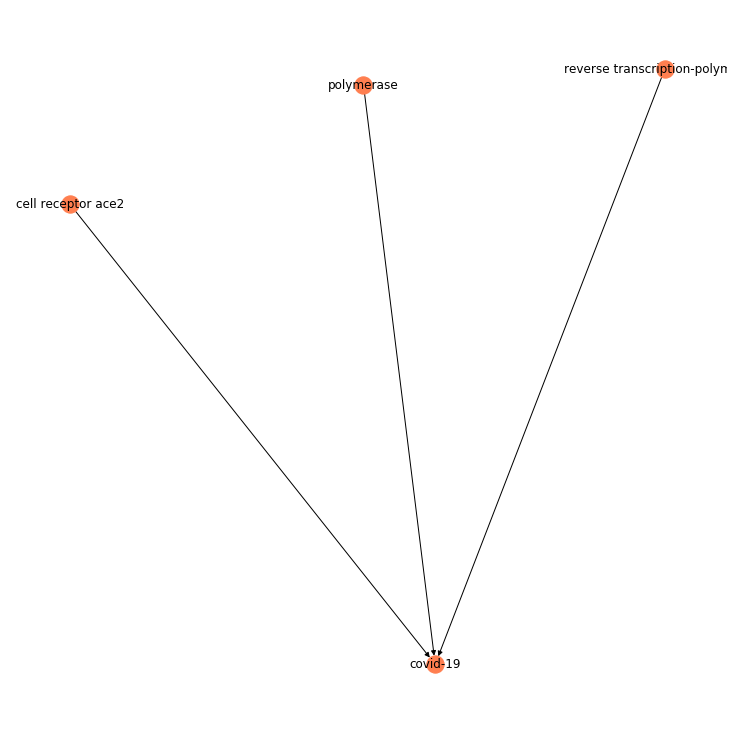

In [37]:
# Covid papers
covid_df = new_df[new_df['disease']=='covid-19']
len(covid_df)

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(covid_df, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


plt.figure(figsize=(10,10))

# pos = nx.spring_layout(G)
pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

nx.draw(G, 
        with_labels=True, 
        node_color='coral', 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()
